In [1]:
!pip install nbimporter

In [2]:
import numpy as np
import pandas as pd
import nbimporter 
import matrix_factorization
np.random.seed(0)

Importing Jupyter notebook from matrix_factorization.ipynb


In [3]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [5]:
ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [6]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
R_df.shape

(6040, 3706)

In [8]:
np.array(R_df.values, dtype=int)

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [10]:
# names = ['user_id', 'item_id', 'rating', 'timestamp']
# df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
# df.head()

In [11]:
# n_users = df.user_id.unique().shape[0]
# n_items = df.item_id.unique().shape[0]
# ratings = np.zeros((n_users, n_items))
# for row in df.itertuples():
#     ratings[row[1]-1, row[2]-1] = row[3]
# ratings

In [12]:
ratings = np.array(R_df.values, dtype=int)
n_users = ratings.shape[0]
n_items = ratings.shape[1]

In [13]:
def get_sparsity(mat):
    print (str(n_users) + ' users')
    print (str(n_items) + ' items')
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [14]:
print ('Sparsity: {:4.2f}%'.format(get_sparsity(ratings)))

6040 users
3706 items
Sparsity: 4.47%


In [15]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=20, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
#     print(test)
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [16]:
train, test = train_test_split(ratings)

In [17]:
train.shape

(6040, 3706)

In [18]:
test.shape

(6040, 3706)

In [19]:
ratings

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
get_sparsity(ratings)

6040 users
3706 items


4.468362562231285

In [21]:
get_sparsity(train)

6040 users
3706 items


3.9286971547839014

In [22]:
get_sparsity(test)

6040 users
3706 items


0.5396654074473827

In [23]:
MF_SGD = matrix_factorization.ExplicitMF(train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [10]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 10
	current iteration: 10
Train mse: 0.8264795643096374
Test mse: 0.9051574489352089


##################################################################################################################

# ####################################### GANS ###################################################

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [25]:
batch_size = 5

In [26]:
def make_some_noise(batch_size):
    return torch.rand(batch_size,100)

In [27]:
make_some_noise(batch_size)

tensor([[0.2724, 0.1909, 0.7126, 0.6766, 0.2547, 0.3323, 0.6038, 0.5984, 0.8583,
         0.0273, 0.2466, 0.4032, 0.1908, 0.0653, 0.1791, 0.0142, 0.9232, 0.3020,
         0.1414, 0.6891, 0.2697, 0.3293, 0.2442, 0.0925, 0.3441, 0.9606, 0.8536,
         0.4706, 0.6018, 0.4960, 0.9978, 0.8719, 0.0905, 0.5962, 0.2854, 0.3535,
         0.6140, 0.3546, 0.1361, 0.2737, 0.1378, 0.1308, 0.2716, 0.8233, 0.5087,
         0.9443, 0.7801, 0.7148, 0.8978, 0.4628, 0.4256, 0.2154, 0.7963, 0.5742,
         0.4585, 0.3001, 0.8462, 0.2175, 0.6743, 0.8840, 0.3304, 0.1265, 0.9302,
         0.2023, 0.2214, 0.9326, 0.9632, 0.4742, 0.7701, 0.6497, 0.4705, 0.2710,
         0.2724, 0.0856, 0.6046, 0.6616, 0.7556, 0.0248, 0.2424, 0.0152, 0.1226,
         0.8116, 0.4953, 0.0356, 0.7205, 0.5250, 0.0994, 0.7203, 0.2382, 0.6143,
         0.7746, 0.7050, 0.1907, 0.1479, 0.0710, 0.1017, 0.7887, 0.1361, 0.0546,
         0.6017],
        [0.1227, 0.8583, 0.8935, 0.2397, 0.2172, 0.7321, 0.2306, 0.5543, 0.2085,
         0

In [28]:
# defining generator class

class generator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(generator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,1000),
                                 nn.Tanh(),
                                 nn.Linear(1000,800),
                                 nn.Tanh(),
                                 nn.Linear(800,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]

In [29]:
# defining discriminator class

class discriminator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,300),
                                 nn.Tanh(),
                                 nn.Linear(300,200),
                                 nn.Tanh(),
                                 nn.Linear(200,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [30]:
dis = discriminator(ratings.shape[1], 1)
gen = generator(100, ratings.shape[1])

In [31]:
dis

discriminator(
  (net): Sequential(
    (0): Linear(in_features=3706, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [39]:
gen

generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=3706, bias=True)
    (7): Sigmoid()
  )
)

In [40]:
d_steps = 300
g_steps = 300

criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=0.0001, momentum=0.9)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)

# printing_steps = 200

epochs = 50

In [41]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]
    
get_random_batch(train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 2.]])

In [42]:
train = torch.autograd.Variable(torch.Tensor(train))

In [54]:
def d_my(x_r, x_g):
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [56]:
import torch.nn.functional as F
eval_losses = []
for epoch in range(10):
#     print (epoch)

    # training discriminator
    gen.train()
    dis.train()
    for d_step in range(d_steps):
        dis.zero_grad()
        
        # training discriminator on real data
        real_rows = get_random_batch(train, batch_size)
        discriminator_real_outputs = dis(real_rows)
   
        dis_real_loss = criteriond1(discriminator_real_outputs, Variable(torch.ones(batch_size,1)))
    
        dis_real_loss.backward()

        # training discriminator on data produced by generator
        z_vector = make_some_noise(batch_size)
        #output from generator is generated        
        fake_rows = gen(z_vector).detach()
#         print(fake_rows[:20])
        dis_fake_out = dis(fake_rows)
        dis_fake_loss = criteriond1(dis_fake_out, Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()

        optimizerd1.step()
        
    # training generator
    for g_step in range(g_steps):
        gen.zero_grad()
        
        #generating data for input for generator
        z_vector = make_some_noise(batch_size)
        
        fake_rows = gen(z_vector)
#         print(fake_rows.shape, z_vector.shape)
#         print(fake_rows[:20])
        dis_out_gen_training = dis(fake_rows)
        gen_loss = criteriond2(dis_out_gen_training, Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()

    # evaluation
    if epoch % 10: # todo- to change
        gen.eval()
        z_vector_eval = make_some_noise(128)
        fake_rows_eval = gen(z_vector_eval)
        real_rows_eval = get_random_batch(train, 128)
#         print(fake_rows[0][:10]) enable to see some results
        eval_loss = F.mse_loss(fake_rows_eval, real_rows_eval, reduction='mean')
        eval_losses.append(eval_loss)
#         print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
        print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real_rows_eval, fake_rows_eval)))
        

Epoch number 1. L1 distance between random real and fake samples 39724.35546875
Epoch number 2. L1 distance between random real and fake samples 39453.58984375
Epoch number 3. L1 distance between random real and fake samples 39231.875
Epoch number 4. L1 distance between random real and fake samples 49625.38671875
Epoch number 5. L1 distance between random real and fake samples 50281.29296875
Epoch number 6. L1 distance between random real and fake samples 46055.30859375
Epoch number 7. L1 distance between random real and fake samples 47140.0390625
Epoch number 8. L1 distance between random real and fake samples 37950.50390625
Epoch number 9. L1 distance between random real and fake samples 51845.984375


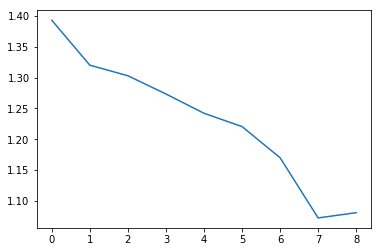

In [57]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [58]:
z_vector = make_some_noise(16)
fake_rows = gen(z_vector)

In [59]:
# as we see generator produces very similar vectors 
fake_rows[:,:9]

tensor([[4.9494, 0.8310, 0.6297, 0.0555, 0.0775, 1.7679, 0.1614, 0.1407, 0.0817],
        [4.9494, 0.8302, 0.6294, 0.0555, 0.0775, 1.7672, 0.1613, 0.1407, 0.0815],
        [4.9495, 0.8305, 0.6289, 0.0555, 0.0775, 1.7673, 0.1612, 0.1406, 0.0815],
        [4.9492, 0.8325, 0.6301, 0.0558, 0.0779, 1.7683, 0.1619, 0.1411, 0.0820],
        [4.9494, 0.8312, 0.6300, 0.0557, 0.0777, 1.7676, 0.1617, 0.1410, 0.0819],
        [4.9494, 0.8310, 0.6295, 0.0556, 0.0776, 1.7661, 0.1614, 0.1407, 0.0817],
        [4.9495, 0.8300, 0.6291, 0.0554, 0.0773, 1.7661, 0.1609, 0.1404, 0.0815],
        [4.9496, 0.8300, 0.6285, 0.0554, 0.0773, 1.7670, 0.1609, 0.1404, 0.0813],
        [4.9493, 0.8311, 0.6298, 0.0557, 0.0777, 1.7676, 0.1616, 0.1409, 0.0818],
        [4.9492, 0.8321, 0.6311, 0.0558, 0.0779, 1.7685, 0.1621, 0.1411, 0.0820],
        [4.9495, 0.8302, 0.6291, 0.0554, 0.0773, 1.7663, 0.1610, 0.1406, 0.0814],
        [4.9494, 0.8305, 0.6294, 0.0555, 0.0774, 1.7670, 0.1613, 0.1408, 0.0817],
        [4.9493,

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os
# from tensorboard_logger import configure, log_value

In [61]:
lrD = 5e-4
lrG = 5e-4
batch_size = 100
cuda = True
epochs = 60 #change
device = 5
seed = 1
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-2 # constant for L2 penalty (diversity)
name = "mnist-experiment"
# configure("runs/run-" + args.name, flush_secs=5)
torch.manual_seed(seed)


data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    ])), batch_size=batch_size, shuffle=True)

In [62]:
# length=6
# batch_size=5

In [63]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
        filt = (torch.abs((real != 0).float() * fake - real))/real.shape[0]
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())
#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = nn.Sequential(
                                 nn.Linear(nz,1024),
                                 nn.ReLU(),
                                 nn.Linear(1024,features_length),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD(use_cuda=False)
netG = NetG()
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [64]:
one = torch.FloatTensor([1])
mone = one * -1
cuda = False
if cuda is True:
    netD.cuda()
    netG.cuda()
    one, mone = one.cuda(), mone.cuda()

In [65]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [66]:
# batch_size = 5

In [67]:
def getRealSample(length=6):
     return Variable(torch.IntTensor(np.random.choice([0, 1], size=(batch_size, length))))

In [68]:
get_random_batch(train, batch_size=batch_size).shape

torch.Size([100, 3706])

In [69]:
len(data_loader)

600

In [72]:
steps_per_epoch = 100
gen_iterations = 0
eval_losses = []
for epoch in range(epochs):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter and i < len(data_loader):
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real)
#             print('fake', fake[:,0].sum())
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter and i < len(data_loader):
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            fake = netG(noisev)
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
#                 print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

Epoch number 5. my distance between random real and fake samples 8436.400390625
Epoch number 11. my distance between random real and fake samples 11909.0234375
Epoch number 17. my distance between random real and fake samples 10387.798828125
Epoch number 23. my distance between random real and fake samples 14421.748046875
Epoch number 29. my distance between random real and fake samples 14294.9765625
Epoch number 35. my distance between random real and fake samples 11947.38671875
Epoch number 41. my distance between random real and fake samples 11936.1904296875
Epoch number 47. my distance between random real and fake samples 9395.40625
Epoch number 52. my distance between random real and fake samples 11183.8369140625
Epoch number 58. my distance between random real and fake samples 13240.017578125


In [73]:
# torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda()).cuda().type()
torch.abs((real != 0).float() * fake - real).type()

'torch.FloatTensor'

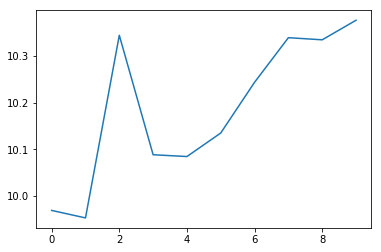

In [74]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [75]:
batch_size = ratings.shape[0]
batch_size

6040

In [76]:
noise = torch.randn(batch_size, nz)
if cuda: 
    noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)

In [78]:
print(5, (5 == fake.round()).sum(), (5 == ratings.round()).sum())
print(4, (4 == fake.round()).sum(), (4 == ratings.round()).sum())
print(3, (3 == fake.round()).sum(), (3 == ratings.round()).sum())
print(2, (2 == fake.round()).sum(), (2 == ratings.round()).sum())
print(1, (1 == fake.round()).sum(), (1 == ratings.round()).sum())
print(0, (0 == fake.round()).sum(), (0 == ratings.round()).sum())

5 tensor(636115) 226310
4 tensor(8860694) 348971
3 tensor(7940416) 261197
2 tensor(3341654) 107557
1 tensor(1331974) 56174
0 tensor(273387) 21384031


In [79]:
fake[:10,:20]

tensor([[4.0591, 3.5510, 2.9742, 2.8604, 4.0094, 3.0178, 2.7680, 2.2719, 2.9051,
         3.0136, 3.0993, 2.9574, 3.8534, 3.2507, 2.9465, 3.9413, 3.8007, 3.1530,
         3.2473, 3.0627],
        [4.0601, 3.5852, 2.8769, 2.8308, 4.0882, 3.6063, 2.7653, 2.4862, 2.9444,
         2.9707, 3.2661, 3.0193, 3.9266, 3.3233, 2.8870, 3.9665, 3.8255, 3.3479,
         3.2736, 3.1026],
        [4.1622, 3.5850, 3.1462, 2.9236, 4.6632, 3.9361, 2.8592, 2.5621, 3.1746,
         3.1400, 3.3326, 3.0300, 3.8986, 3.4844, 2.9900, 3.8925, 3.9823, 2.9389,
         3.9002, 3.1791],
        [4.0803, 3.4626, 2.8582, 2.9130, 4.1859, 3.1288, 2.4034, 2.7564, 2.8815,
         2.9721, 3.2723, 2.9647, 3.8735, 3.3001, 2.9566, 3.9702, 3.6648, 3.3650,
         3.0370, 3.1114],
        [4.0627, 3.5923, 2.8465, 2.9615, 4.2637, 2.8205, 2.8491, 2.2932, 2.9890,
         3.0244, 3.1039, 2.9370, 3.8074, 3.2956, 2.9953, 3.9462, 3.9764, 3.1712,
         3.4970, 3.0632],
        [4.1067, 3.7224, 3.0721, 3.0755, 4.4314, 3.4495, 3.0

In [80]:
(0 == fake.round()).sum()

tensor(273387)

In [252]:
(5 == fake.round()).sum()

tensor(10101)

In [253]:
(4 == fake.round()).sum()

tensor(144859)

In [254]:
(3 == fake.round()).sum()

tensor(138160)

In [255]:
(2 == fake.round()).sum()

tensor(54054)

In [256]:
(1 == fake.round()).sum()

tensor(20781)

In [265]:
(0 == ratings.round()).sum()

21384031

In [266]:
(3 == ratings.round()).sum()

261197

In [263]:
(5 == ratings.round()).sum()

226310

In [264]:
(4 == ratings.round()).sum()

348971

In [259]:
batch_size

100

In [260]:
def random_row(n=10):
    elements = [0, 1, 2, 3, 4, 5]
    probabilities = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]
    return np.random.choice(elements, 10, p=probabilities)

In [261]:
random_row(n=10)

array([0, 0, 0, 4, 2, 0, 5, 0, 0, 2])

In [71]:
def d_dwgan(x_r, x_g):
    return sum(x_r != x_g)

In [102]:
def d_my(x_r, x_g):
    return np.sum(np.abs((x_r != 0).astype(int) * x_g - x_r))

In [103]:
d_my(x_r_2, x_g_2)

2

In [104]:
x_r_1 = np.array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0])
x_g_1 = np.array([0, 0, 3, 0, 4, 0, 0, 0, 0, 0])

x_r_2 = np.array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0])
x_g_2 = np.array([0, 5, 3, 0, 4, 4, 0, 0, 0, 0])

In [105]:
x_r_1, x_g_1

(array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0]), array([0, 0, 3, 0, 4, 0, 0, 0, 0, 0]))

In [106]:
x_r_2, x_g_2

(array([0, 0, 4, 0, 5, 0, 0, 0, 0, 0]), array([0, 5, 3, 0, 4, 4, 0, 0, 0, 0]))

In [107]:
d_dwgan(x_r_1, x_g_1)

2

In [108]:
d_dwgan(x_r_2, x_g_2)

4

In [109]:
d_my(x_r_1, x_g_1)

2

In [110]:
d_my(x_r_2, x_g_2)

2

In [115]:
x_r = random_row(n=10)
x_g = random_row(n=10)

print('x real', x_r)
print('x gen ', x_g)

x real [0 0 5 0 0 5 1 3 0 0]
x gen  [1 0 3 5 0 0 2 0 0 5]


In [116]:
d_dwgan(x_r, x_g)

7

In [117]:
d_my(x_r, x_g)

11